In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
import keras
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Loading & preprocessing the data

In [2]:
df = pd.read_csv('/content/drive/MyDrive/mental_health.csv')
df

,text,label
0,dear american teens question dutch person hear...,0
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,0
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1
...,...,...
27972,posting everyday people stop caring religion ...,0
27973,okay definetly need hear guys opinion ive pret...,0
27974,cant get dog think ill kill myselfthe last thi...,1
27975,whats point princess bridei really think like ...,1


In [3]:
def make_lower(text):
    return text.lower()

In [4]:
def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

In [5]:
df['text'] = df['text'].apply(make_lower)
df['text'] = df['text'].apply(remove_punct)
df.head()

,text,label
0,dear american teens question dutch person hear...,0
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,0
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1


In [9]:
stop_words = stopwords.words('english')
stop_words.append('and')

In [11]:
def clean(text):
    words = text.split(' ')
    new_words = []
    for w in words:
        if w not in stop_words and w.isalpha() == True:
            new_words.append(w)
    new_sent = ' '.join(new_words)
    return new_sent

In [12]:
df['text'] = df['text'].apply(clean)

In [13]:
X = df['text']
Y = df['label']

In [14]:
df['label'].value_counts()

0    14139
1    13838
Name: label, dtype: int64

In [15]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size = 0.25, random_state = 40)
len(Xtrain), len(Xtest)

(20982, 6995)

# Usinf Tokenizer

In [16]:
tokenizer = Tokenizer(num_words = 1000, oov_token = '<OOV>')
tokenizer.fit_on_texts(Xtrain)

In [17]:
word_index = tokenizer.word_index
len(word_index)

61571

In [18]:
max_length = max([len(sent.split(' ')) for sent in Xtrain])
max_length

2525

In [19]:
train_sequences = tokenizer.texts_to_sequences(Xtrain)
train_padded_sequences = pad_sequences(train_sequences, maxlen = max_length, padding = 'post')

In [20]:
test_sequences = tokenizer.texts_to_sequences(Xtest)
test_padded_sequences = pad_sequences(test_sequences, maxlen = max_length, padding = 'post')

# Building model

In [21]:
model = keras.Sequential([
    layers.Embedding(input_dim = len(word_index)+1, output_dim = 16, input_length = max_length),

    layers.Bidirectional(layer  = layers.LSTM(units = 32)),
    layers.Dropout(0.4),

    layers.Dense(units = 64, activation = 'relu'),
    layers.Dropout(0.4),
    layers.Dense(units = 1, activation = 'sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2525, 16)          985152    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12544     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                        

In [22]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'accuracy')

In [23]:
hist = model.fit(train_padded_sequences, Ytrain, validation_data = (test_padded_sequences, Ytest), epochs = 10)

Epoch 1/10
656/656 [==============================] - 97s 136ms/step - loss: 0.3304 - accuracy: 0.8591 - val_loss: 0.2664 - val_accuracy: 0.8964
Epoch 2/10
656/656 [==============================] - 87s 133ms/step - loss: 0.2369 - accuracy: 0.9122 - val_loss: 0.2665 - val_accuracy: 0.8952
Epoch 3/10
656/656 [==============================] - 87s 132ms/step - loss: 0.2299 - accuracy: 0.9155 - val_loss: 0.2664 - val_accuracy: 0.9006
Epoch 4/10
656/656 [==============================] - 89s 135ms/step - loss: 0.2207 - accuracy: 0.9181 - val_loss: 0.2543 - val_accuracy: 0.8984
Epoch 5/10
656/656 [==============================] - 88s 134ms/step - loss: 0.2106 - accuracy: 0.9216 - val_loss: 0.2611 - val_accuracy: 0.9032
Epoch 6/10
656/656 [==============================] - 88s 134ms/step - loss: 0.2013 - accuracy: 0.9257 - val_loss: 0.2644 - val_accuracy: 0.9012
Epoch 7/10
656/656 [==============================] - 88s 134ms/step - loss: 0.2022 - accuracy: 0.9243 - val_loss: 0.2558 - val_ac

Text(0.5, 1.0, 'Loss')

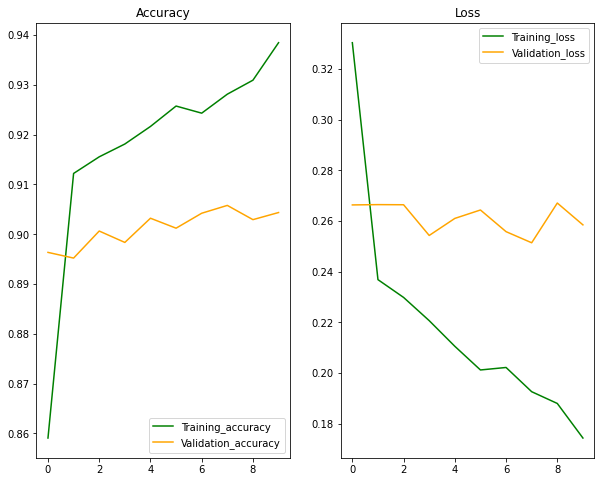

In [25]:
plt.figure(figsize = (10, 8))

plt.subplot(1, 2, 1)
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(10)
plt.plot(epochs, train_acc, label = 'Training_accuracy', color = 'green')
plt.plot(epochs, val_acc, label = 'Validation_accuracy', color = 'orange')
plt.legend(loc = 'lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(10)
plt.plot(epochs, train_loss, label = 'Training_loss', color = 'green')
plt.plot(epochs, val_loss, label = 'Validation_loss', color = 'orange')
plt.legend(loc = 'upper right')
plt.title('Loss')

# Predictions

In [26]:
Ypred = model.predict(test_padded_sequences)

219/219 [==============================] - 14s 59ms/step


In [30]:
Ypred = np.round(Ypred)

In [32]:
print(classification_report(Ytest, Ypred))

              precision    recall  f1-score   support

           0       0.89      0.92      0.91      3516
           1       0.92      0.88      0.90      3479

    accuracy                           0.90      6995
   macro avg       0.91      0.90      0.90      6995
weighted avg       0.90      0.90      0.90      6995



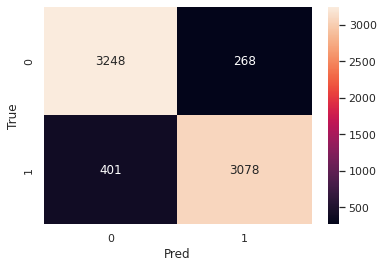

In [31]:
cm = confusion_matrix(Ytest, Ypred)
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Pred')
plt.ylabel('True')
plt.show()